In [1]:
pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Exploratory data analysis - UK & France Day-Ahead Power Prices

In this notebook we:
1. Explore historical hourly prices for UKL and France (Jan-July 2025)
2. Construct the spread series (UK & FR) in EUR/MWh
3. Analyse correlation, volatility, and descriptive statistics.
4. Produce visualisations to understand price behaviour.

In [2]:
import pandas as pd  
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath("/Users/Lyndon.Odia/Desktop/lo-devx/power-spread-option-pricing-main"))
from config import raw_data_dir, processed_data_dir, API_KEY, FR_DOMAIN, START_DATE, END_DATE, FX_GBP_EUR
 

In [3]:
# Settings for plots
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
# Load merged hourly dataset - 
data_path = os.path.join(processed_data_dir, "UK_FR_day_ahead_hourly_010125-31072025.csv")
df = pd.read_csv(data_path, parse_dates=["datetime"])

In [5]:
# Ensure sorted and clean
df = df.sort_values("datetime").reset_index(drop=True)

In [6]:
#Convert GBP to EUR using the exchange rate from config (1.17)
FX_GBP_EUR  
if "UK_price_eur" not in df.columns:
   df["UK_price_eur"] = df["UK_price"] * FX_GBP_EUR
   
# Create spread (EUR/MWh) - difference between the UK and France prices
df["spread_eur"] = df["UK_price_eur"] - df["FR_price"]
df.head(5)

,datetime,FR_price,UK_price,UK_price_eur,spread_eur
0,2025-01-01 00:00:00+00:00,18.92,77.221,90.34857,71.42857
1,2025-01-01 01:00:00+00:00,16.66,70.001,81.90117,65.24117
2,2025-01-01 02:00:00+00:00,13.10,74.074,86.66658,73.56658
3,2025-01-01 03:00:00+00:00,5.90,78.937,92.35629,86.45629
4,2025-01-01 04:00:00+00:00,9.27,62.961,73.66437,64.39437


In [7]:
#save to processed path
output_path_2 = os.path.join(processed_data_dir, "UK_FR_day_ahead_hourly_merged_spread.csv")
df.to_csv(output_path_2, index=False)
print(f"Merged hourly dataset saved to {output_path_2}")

Merged hourly dataset saved to /Users/Lyndon.Odia/Desktop/lo-devx/power-spread-option-pricing-main/data/processed/UK_FR_day_ahead_hourly_merged_spread.csv


In [8]:
#data health check
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874 entries, 0 to 4873
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   datetime      4874 non-null   datetime64[ns, UTC]
 1   FR_price      4874 non-null   float64            
 2   UK_price      4874 non-null   float64            
 3   UK_price_eur  4874 non-null   float64            
 4   spread_eur    4874 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 190.5 KB
None
          FR_price     UK_price  UK_price_eur   spread_eur
count  4874.000000  4874.000000   4874.000000  4874.000000
mean     68.063695    69.319251     81.103523    13.039828
std      51.209212    10.131403     11.853742    50.897855
min    -118.010000    35.217000     41.203890  -370.709610
25%      25.212500    62.321750     72.916447   -25.134222
50%      64.055000    69.574500     81.402165    17.131940
75%     107.595000    76.

In [9]:
# Check date range and hourly continuity
print("Start:", df["datetime"].min(), "End:", df["datetime"].max())
expected_hours = pd.date_range(df["datetime"].min(), df["datetime"].max(), freq="h")
missing = expected_hours.difference(df["datetime"])
print("Missing hours:", len(missing))

Start: 2025-01-01 00:00:00+00:00 End: 2025-07-31 22:00:00+00:00
Missing hours: 213


# 213 missing hours observations identified after cleaning
Missing hours arise mainly from:
- Coverage mismatches between the ENTSO-E France API feed and the UK Excel dataset (some days or partial hours missing in one source).
- Removal of zero values
- Duplicate timestamps around daylight saving changes that were dropped during UTC normalisation.

Negative prices were kept, as they represent real market conditions during oversupply events, and are important for spread volatility and optionality valuation.


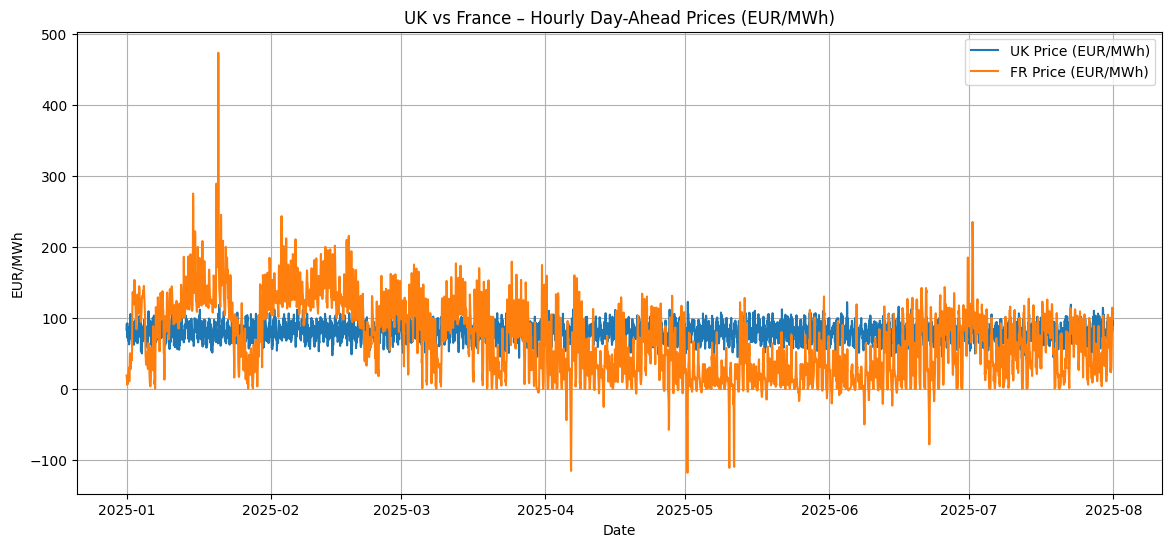

In [10]:
#Plotting the UK and France prices
plt.figure(figsize=(14,6))
plt.plot(df["datetime"], df["UK_price_eur"], label="UK Price (EUR/MWh)")
plt.plot(df["datetime"], df["FR_price"], label="FR Price (EUR/MWh)")
plt.title("UK vs France – Hourly Day-Ahead Prices (EUR/MWh)")
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.show()

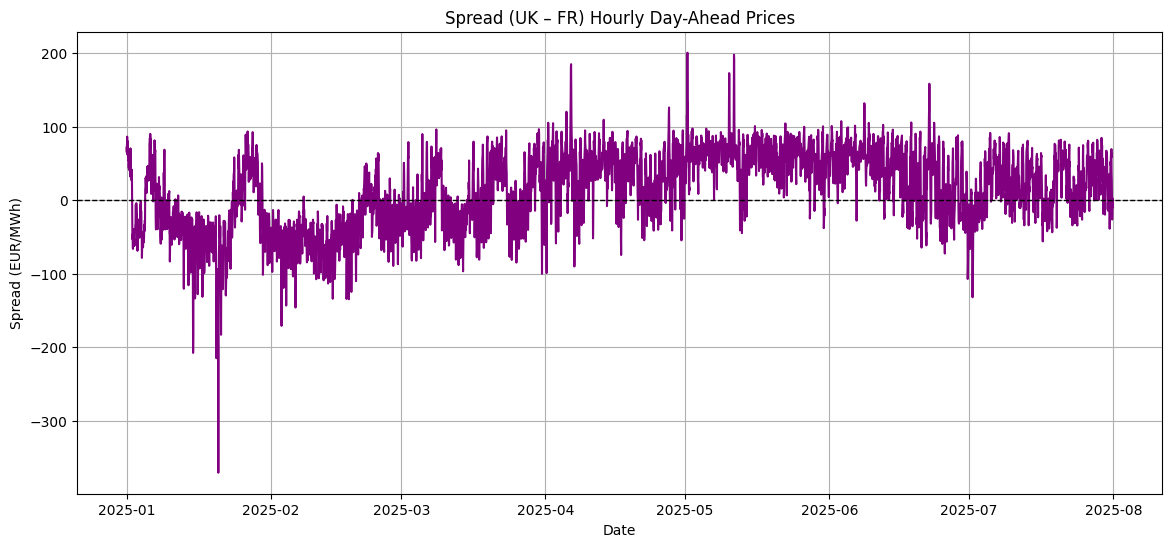

In [11]:
#Generate plot spread - spread eur
plt.figure(figsize=(14,6))
plt.plot(df["datetime"], df["spread_eur"], color="purple")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Spread (UK – FR) Hourly Day-Ahead Prices")
plt.xlabel("Date")
plt.ylabel("Spread (EUR/MWh)")
plt.grid(True)
plt.show()

In [12]:
# Pearson correlation between hourly prices
corr = df["UK_price_eur"].corr(df["FR_price"])

# Compute hourly log-returns
rets = np.log(df[["UK_price_eur", "FR_price"]]).diff()
rets["spread"] = np.log(df["spread_eur"]).diff()

# Clean infinite values and drop NaNs in FR_price
rets["FR_price"] = rets["FR_price"].replace([np.inf, -np.inf], np.nan)
rets = rets.dropna(subset=["FR_price"])

# Hourly volatilities of returns
uk_vol_hourly = rets["UK_price_eur"].std()
fr_vol_hourly = rets["FR_price"].std()
spread_vol_hourly = rets["spread"].std()

# Annualise (8760 hours/year)
hours_in_year = 8760
uk_vol_ann = uk_vol_hourly * np.sqrt(hours_in_year)
fr_vol_ann = fr_vol_hourly * np.sqrt(hours_in_year)
spread_vol_ann = spread_vol_hourly * np.sqrt(hours_in_year)

print(f"Correlation (UK vs FR): {corr:.3f}")
print(f"UK Volatility – Hourly: {uk_vol_hourly:.2f} EUR/MWh | Annualised: {uk_vol_ann:.2f}")
print(f"FR Volatility – Hourly: {fr_vol_hourly:.2f} EUR/MWh | Annualised: {fr_vol_ann:.2f}")
print(f"Spread Volatility – Hourly: {spread_vol_hourly:.2f} EUR/MWh | Annualised: {spread_vol_ann:.2f}")

Correlation (UK vs FR): 0.142
UK Volatility – Hourly: 0.17 EUR/MWh | Annualised: 16.08
FR Volatility – Hourly: 0.73 EUR/MWh | Annualised: 68.60
Spread Volatility – Hourly: 0.83 EUR/MWh | Annualised: 77.26


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Explanation of annualised vol
Annualised vol numbers are correct for your data and method. They are high because your market experiences real, large price moves

In [13]:
#DELETE THIS 
print(rets.describe())

       UK_price_eur     FR_price       spread
count   4479.000000  4479.000000  2237.000000
mean      -0.002760    -0.003662     0.002101
std        0.171823     0.732950     0.825498
min       -0.619670    -7.210080    -4.823533
25%       -0.116845    -0.147046    -0.300883
50%       -0.002983    -0.022031    -0.008667
75%        0.109526     0.143284     0.267304
max        0.667756     7.696667     6.456861


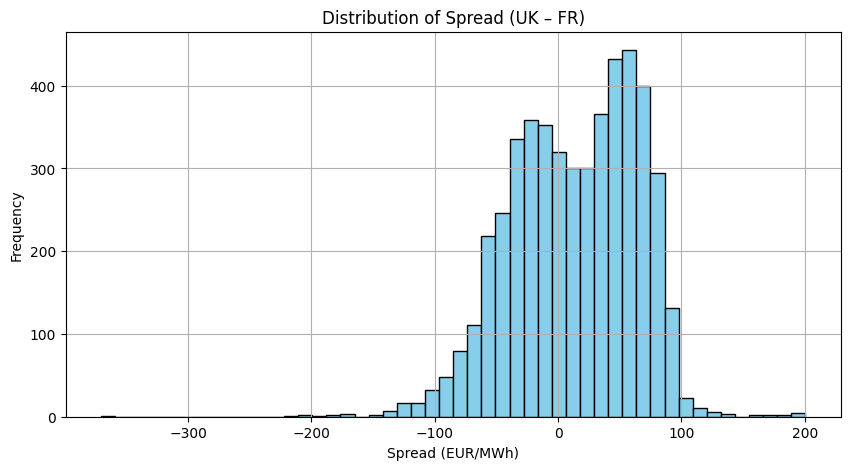

In [14]:
# Distribution of the spread - shows us how often the spread falls within certain ranges
plt.figure(figsize=(10,5))
plt.hist(df["spread_eur"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Spread (UK – FR)")
plt.xlabel("Spread (EUR/MWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Distribution of Hourly Spread (UK-FR)

The distribution shows how often the hourly price difference between the UK and France falls within certain ranges.

### Key Observations
- The spread is centered slightly above zero, meaning the UK market tends to trade marginally higher on average than France.
- The distribution is right-skewed, with a long positive tail; indicating occasional periods when UK prices spike far above France (for example during UK system stress or low wind generation).
- There is a wide dispersion (range roughly −300 to +200 €/MWh), showing that large hourly divergences do occur — crucial for the optionality value of interconnector capacity.
- Negative spreads (UK < FR) are frequent too, typically when France exports heavily (e.g. during high nuclear availability).
- Overall, this non-normal, skewed distribution confirms that spread options capture asymmetric profit opportunities — traders can gain from rare but large positive differentials.

In [15]:
#DELETE THIS
print(rets["FR_price"].nlargest(5))
print(rets["FR_price"].nsmallest(5))

2374    7.696667
3747    7.376508
3137    6.821653
3943    6.403574
2941    6.236587
Name: FR_price, dtype: float64
2872   -7.210080
2733   -6.799892
3982   -6.617403
2193   -6.584791
3397   -6.519639
Name: FR_price, dtype: float64


In [16]:
#DELETE THIS
print(df.loc[[2387, 3816, 3181, 4019, 2976]])
print(df.loc[[2900, 2756, 4060, 2197, 3449]])

                      datetime  FR_price  UK_price  UK_price_eur  spread_eur
2387 2025-04-12 04:00:00+00:00     32.68    57.596      67.38732    34.70732
3816 2025-06-15 14:00:00+00:00     -0.01    71.780      83.98260    83.99260
3181 2025-05-17 15:00:00+00:00     -0.05    65.272      76.36824    76.41824
4019 2025-06-25 00:00:00+00:00     75.51    62.386      72.99162    -2.51838
2976 2025-05-08 07:00:00+00:00      7.26    57.143      66.85731    59.59731
                      datetime  FR_price  UK_price  UK_price_eur  spread_eur
2900 2025-05-04 15:00:00+00:00      3.16    57.601      67.39317    64.23317
2756 2025-04-28 07:00:00+00:00     67.37    65.444      76.56948     9.19948
4060 2025-06-26 17:00:00+00:00     97.81    73.120      85.55040   -12.25960
2197 2025-04-03 16:00:00+00:00     88.81    87.302     102.14334    13.33334
3449 2025-05-29 23:00:00+00:00     31.11    66.592      77.91264    46.80264


These extreme price moves are legitimate market events, as the data was pulled directly from the ENTSO-E platform. Such near-zero prices can occur in European electricity markets due to oversupply, negative pricing, or market mechanisms. Therefore, these values reflect real market risk and volatility

In [17]:
print(df.loc[rets["FR_price"].nlargest(5).index])
print(df.loc[rets["FR_price"].nsmallest(5).index])

                      datetime  FR_price  UK_price  UK_price_eur  spread_eur
2374 2025-04-11 15:00:00+00:00     22.01    79.577      93.10509    71.09509
3747 2025-06-12 15:00:00+00:00     15.98    88.084     103.05828    87.07828
3137 2025-05-15 16:00:00+00:00     18.35    92.023     107.66691    89.31691
3943 2025-06-21 15:00:00+00:00     60.40    67.304      78.74568    18.34568
2941 2025-05-06 17:00:00+00:00     46.00    74.230      86.84910    40.84910
                      datetime  FR_price  UK_price  UK_price_eur  spread_eur
2872 2025-05-03 08:00:00+00:00      0.01    57.324      67.06908    67.05908
2733 2025-04-27 07:00:00+00:00      0.04    55.283      64.68111    64.64111
3982 2025-06-23 08:00:00+00:00      0.02    65.999      77.21883    77.19883
2193 2025-04-03 09:00:00+00:00      0.04    80.066      93.67722    93.63722
3397 2025-05-27 08:00:00+00:00      0.03    48.180      56.37060    56.34060


### Sumary of EDA insights
- Dataset covers Jan 1 – Jul 31 2025 with 213 missing hourly observations (acceptable coverage).
- Negative prices retained, representing genuine oversupply conditions important for spread optionality.
- Correlation (ρ = 0.142) = weak relationship between UK and FR hourly prices, enhancing optional value.
- Volatility levels:
-> UK ≈ 16 €/MWh (relatively stable market)
-> FR ≈ 66 €/MWh (higher variability, often linked to nuclear generation swings)
- Spread volatility ≈ 77 €/MWh = key driver of the interconnector option’s value.
- Extreme events (large positive/negative spreads) reflect true market risk and justify modeling via both analytical (Kirk) and stochastic (Monte Carlo) methods.